In [139]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats.stats import pearsonr
from IPython.display import display, Markdown, Latex
plt.style.use('ggplot')
from datetime import date
from statsmodels.stats.outliers_influence import variance_inflation_factor
#data_path = '/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/'
import dask.dataframe as dd
from scipy.stats import norm
#from seaborn_qqplot import pplot
import statsmodels.api as sm

import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import numpy as np

import pandas



/var/folders/w3/nxkwqd7x4rjb765dvpmhnksc0000gn/T/ipykernel_8509/1418890169.py:8: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [141]:
pd.set_option('display.max_columns', None)

In [143]:
#load mobility and temperature data
#load heatwave - control dataframe
mobility_heat = pd.read_csv('THI_mobility_heat_clean_90.csv')
heatwave_control = pd.read_csv('THI_heatwave_control_90.csv')

In [145]:
mobility_heat['control_day'] = pd.to_datetime(mobility_heat['control_day'])
mobility_heat['datetime'] = pd.to_datetime(mobility_heat['datetime'])

## Build Intensity Variable


In [150]:
full_df = pd.read_csv('daily_max_THI.csv')

full_df.rename(columns={'time': 'datetime'}, inplace=True)
full_df['datetime'] = pd.to_datetime(full_df['datetime'])
full_df['day'] = pd.DatetimeIndex(full_df['datetime']).day
full_df['month'] = pd.DatetimeIndex(full_df['datetime']).month
full_df['year'] = pd.DatetimeIndex(full_df['datetime']).year
full_df = full_df[~full_df['month'].isin([4, 10])]
full_df['location'] = full_df['adm2'] + ', ' + full_df['adm1']
full_df['datetime_ord'] = [date(x,y,z).toordinal() for x,y,z in zip(full_df['year'], full_df['month'], full_df['day'])]

In [151]:
#merge temperatures from control day onto mobility heat
mobility_heat = mobility_heat.merge(full_df[['datetime', 't2m','thi', 'location']], left_on=['location', 'control_day'], right_on=['location', 'datetime'], suffixes=('_heat', '_control'))

### Create/explore temperature difference variable

In [159]:
mobility_heat['thi_diff'] = mobility_heat['thi_heat'] - mobility_heat['thi_control']

In [161]:
mobility_heat['thi_diff'].describe()

count    4889.000000
mean        6.121331
std         2.822419
min         0.712140
25%         3.977285
50%         5.667423
75%         7.939492
max        18.144627
Name: thi_diff, dtype: float64

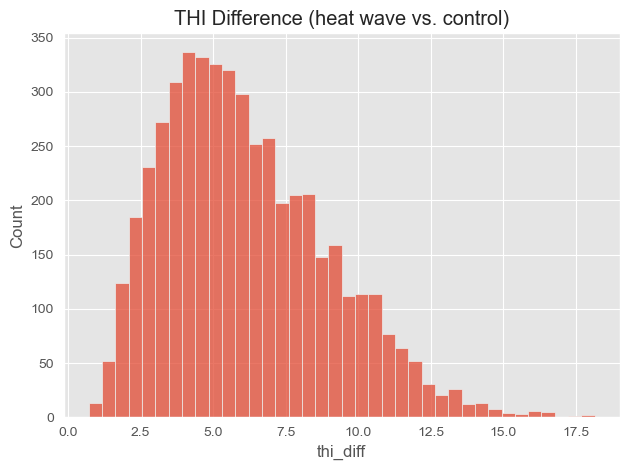

In [163]:
sns.histplot(mobility_heat, x='thi_diff')
plt.title("THI Difference (heat wave vs. control)")
plt.tight_layout()
#plt.savefig(data_path + '/img/12_09_2023/india_temp_diff_dist.png')

### Build Duration Variable
* Duration of heat wave (in days)
* Build variable showing which day of a heatwave it is

In [168]:
heatwave_control.sort_values(by='Heat Wave Duration', inplace=True)

In [170]:
duration_IDs = heatwave_control.drop_duplicates('heat_ID')[['heat_ID', 'Heat Wave Duration']  ]             

In [172]:
duration_IDs.columns = ['heat_ID', 'Heat Wave Duration']

In [174]:
duration_IDs.head()

heat_ID  Heat Wave Duration
2816  2cd31104-5228-4032-9215-c2895d4e9721                 2.0
3008  d94b630d-4996-4e26-bd72-bc301296d421                 2.0
3018  908d632c-c700-4e26-897e-6297dfb99a26                 2.0
3020  71b05268-b2bc-40db-99f3-403a85d1ce2d                 2.0
3028  eafbf136-cf07-434a-ac0a-06f84d6710cf                 2.0

In [176]:
duration_IDs['Heat Wave Duration'].describe()

count    1608.000000
mean        3.381841
std         1.654612
min         2.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        15.000000
Name: Heat Wave Duration, dtype: float64

In [178]:
#drop original heatwave duration variable
heatwave_control.drop('Heat Wave Duration', axis=1, inplace=True)

In [180]:
#merge duration ID dataframe onto heatwave control
heatwave_control = heatwave_control.merge(duration_IDs, on='heat_ID', how='left')

In [182]:
heatwave_control.drop_duplicates(['location', 'datetime'], inplace=True)

In [184]:
heatwave_control['dur_ranking'] = heatwave_control['Heat Wave Duration'].rank(pct=True)

In [186]:
#groupby each heatwave, sort by date, assign increasing rank for each passing day
heat_stage = heatwave_control.groupby('heat_ID').apply(lambda x: x.datetime.sort_values().rank()).reset_index()

/var/folders/w3/nxkwqd7x4rjb765dvpmhnksc0000gn/T/ipykernel_8509/111197883.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heat_stage = heatwave_control.groupby('heat_ID').apply(lambda x: x.datetime.sort_values().rank()).reset_index()


In [187]:
heat_stage.columns=['heat_ID', 'index', 'stage']

In [188]:
heat_stage['stage'].max()

15.0

In [192]:
x = heat_stage.merge(duration_IDs, on='heat_ID')

In [194]:
heatwave_control.drop('index', axis=1, inplace=True)

In [196]:
heatwave_control.reset_index(inplace=True)

In [198]:
heatwave_control = heatwave_control.merge(heat_stage, on=['index', 'heat_ID'])

In [200]:
heatwave_control['datetime'] = pd.to_datetime(heatwave_control['datetime'])

In [202]:
heatwave_control['stage'].max()

15.0

In [204]:
mobility_heat['date_heat'] = pd.to_datetime(mobility_heat['date_heat'])

In [206]:
#merge temporal variables into mobility_heat

mobility_heat = mobility_heat.merge(heatwave_control[['location', 'datetime', 'Heat Wave Duration', 'dur_ranking', 'stage']], left_on=['location', 'date_heat'], right_on=['location', 'datetime'])

In [210]:
mobility_heat.reset_index(inplace=True)

In [212]:
mobility_heat['month'] = [x.month for x in mobility_heat['datetime']]

In [214]:
mobility_heat['month'].unique()

array([5, 6, 7, 8, 9])

In [216]:
mobility_heat.drop_duplicates('heat_ID')['Heat Wave Duration'].describe()

count    1536.000000
mean        3.408203
std         1.664157
min         2.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        15.000000
Name: Heat Wave Duration, dtype: float64

#### Hard-coded early heatwave definition OUTDATED


In [226]:
# format final variables
mobility_heat['stage_frac'] = (mobility_heat['stage'] / mobility_heat['Heat Wave Duration'] )
# four or five days?
mobility_heat['heatwave_dur'] = mobility_heat['Heat Wave Duration'] >= 4

In [228]:
mobility_heat['month'] = [x.month for x in pd.to_datetime(mobility_heat['date_control'])]

In [230]:
mobility_heat['date_control'] = pd.to_datetime(mobility_heat['date_control'])

## Merge social and physical variables

In [233]:
soc_phys = pd.read_csv('social_and_physical_variables.csv',index_col=0)

In [235]:
mobility_heat= mobility_heat.merge(soc_phys[['location', 'mean_elev', 'coast', 'HDI_dec', 'popdens_dec', 'over60_dec']], on='location')

In [237]:
mobility_heat['elev_1500m'] = mobility_heat['mean_elev'] >= 1500

In [239]:
mobility_heat['elev_1500m'] = mobility_heat['elev_1500m'] * 1

### Calculate the percentage change of Baidu mobility index

In [242]:
mobility_baseline = pd.read_csv('mobility_data_clean/bd_mobility_china.csv')

In [244]:
mobility_baseline = mobility_baseline[mobility_baseline['date']<20210101].groupby(['location','dayofweek'])['mob_index'].mean().reset_index()

In [246]:
mobility_baseline.rename(columns={'dayofweek':'day_of_week'},inplace=True)

In [248]:
mobility_baseline['day_of_week'] = mobility_baseline['day_of_week'] - 1

In [250]:
mobility_heat = pd.merge(mobility_heat,mobility_baseline,on=['location','day_of_week'],how='left')

In [252]:
mobility_heat.rename(columns={'mob_index':'baseline_mobility'},inplace=True)

In [254]:
mobility_heat['mobility_diff_pct'] = mobility_heat['mobility_difference']/mobility_heat['baseline_mobility']

## Normalized rain variable for heatwave and control day

In [257]:
precip = pd.read_csv('/Users/liangyuan/Desktop/precipitation/daily_sum_precipitation.csv')
precip.rename(columns={'valid_time': 'time'}, inplace=True)
precip['time'] = pd.to_datetime(precip['time'])

In [259]:
#rain from m --> mm
precip['daily_precipitation'] = precip['daily_precipitation'] * 1000

In [261]:
gdf = gpd.read_file('china_city.geojson')
gdf.rename(columns={'name_1': 'adm1'}, inplace=True)
gdf['location'] = gdf['adm2'] + ', ' + gdf['adm1']
gdf.to_crs(epsg='3857', inplace=True)
gdf['area'] = [x.area for x in gdf['geometry']]

In [262]:
#area from m --> km

gdf['area'] = gdf['area'] / 1000

In [263]:
precip = precip.merge(gdf[['location', 'area']], on='location')
precip['rain_normed'] = precip['daily_precipitation'] / precip['area']

In [267]:
precip['rain_standard'] = precip.groupby('location')['rain_normed'].rank(pct=True) * 100

In [269]:
mobility_heat = mobility_heat.merge(precip[['time', 'adm1', 'adm2', 'rain_standard']], left_on=['control_day', 'adm1', 'adm2'], right_on=['time', 'adm1', 'adm2'])

In [271]:
mobility_heat.rename(columns={'rain_standard': "rain_standard_control"}, inplace=True)

In [273]:
mobility_heat = mobility_heat.merge(precip[['time', 'adm1', 'adm2', 'rain_standard']], left_on=['date_heat', 'adm1', 'adm2'], right_on=['time', 'adm1', 'adm2'])

In [275]:
mobility_heat.rename(columns={'rain_standard': "rain_standard_heat"}, inplace=True)

### Prepare final dataset

In [278]:
df = mobility_heat.copy()

In [280]:
df = df[df['mean_elev'] <= 2500]

In [282]:
#set outlier cutoff (how many SDs away from mean)
SD = 4

In [284]:
df['mobility_diff_pct'] = [np.nan if (x >= df['mobility_diff_pct'].mean() + (SD * df['mobility_diff_pct'].std())) | (x <= df['mobility_diff_pct'].mean() - (SD * df['mobility_diff_pct'].std())) else x for x in df['mobility_diff_pct'] ]

In [287]:
df.dropna(how='all', subset=['mobility_diff_pct'], inplace=True)

In [292]:
df = df.iloc[:, 2:]

In [294]:
df['index'] = range(0, len(df))

In [296]:
plt.rcParams["image.cmap"] = 'Reds'

In [302]:
df.to_csv('THI_mobility_heat_w_vars_90_{}SD.csv'.format(SD))